# Routing API comparison 2: Valhalla vs. OSRM vs. OpenRouteService

In the near feature routing services performed in the eClever backend will be done using the Valhalla and OSRM APIs. Hence, it is important to check if these APIs fulfill the requirements of the eClever routing services such as the route-calculation and turn by turn navigation.

In this notebook we have tested the capabilities of the Valhalla and OSRM routing APIs and compared their performance with respect to the currently used OpenRouteService (ORS) API which has been used as our benchmark. 

The methodology we have follows is basically the same we used in a previous [notebook](https://eclever.atlassian.net/wiki/spaces/DEV/pages/3119513605/Routing+API+comparison+Valhalla+vs.+OpenRouteService). This is, we go again step by step and check the different features that are used in our services and check how does it work with the different APIs. For instance, single routes between A and B, multi stop routes, Time/Distance matrices and elevation.

It is also worth mentioning that these tests were performed using our strato trainer server with 32 cores and 135 Gb RAM. As comparison ORS runs on an instance with 8 vCPUs und 64 GB RAM.

From the analysis we found that in general the Valhalla API performs, in general, about 4 to 5 times slower than the currently used ORS API, however the OSRM seem to perform better than ORS, with about 15% performance increase in runtimes. 

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Simple-Route" data-toc-modified-id="Simple-Route-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Simple Route</a></span><ul class="toc-item"><li><span><a href="#Performance-Test" data-toc-modified-id="Performance-Test-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Performance Test</a></span></li></ul></li><li><span><a href="#Route-with-Multiple-stops" data-toc-modified-id="Route-with-Multiple-stops-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Route with Multiple stops</a></span><ul class="toc-item"><li><span><a href="#Performance-test" data-toc-modified-id="Performance-test-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Performance test</a></span></li></ul></li><li><span><a href="#Time/Distance-Matrices" data-toc-modified-id="Time/Distance-Matrices-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Time/Distance Matrices</a></span><ul class="toc-item"><li><span><a href="#Performance-test" data-toc-modified-id="Performance-test-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Performance test</a></span></li><li><span><a href="#Route-preference-(Fastest/Shortest)" data-toc-modified-id="Route-preference-(Fastest/Shortest)-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Route preference (Fastest/Shortest)</a></span></li></ul></li><li><span><a href="#Elevation" data-toc-modified-id="Elevation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Elevation</a></span><ul class="toc-item"><li><span><a href="#Performance-test" data-toc-modified-id="Performance-test-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Performance test</a></span></li></ul></li><li><span><a href="#Summary-and-conclusion" data-toc-modified-id="Summary-and-conclusion-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Summary and conclusion</a></span></li></ul></div>

In [1]:
import importlib.util
import sys

path = '/home/jehamann/eClever/repositories/route-calculation/src/'
sys.path.append(path)

spec = importlib.util.spec_from_file_location("config", path+"config.py")
module = importlib.util.module_from_spec(spec)
sys.modules['config'] = module
spec.loader.exec_module(module)

from openrouteservice import client
import openrouteservice as ors
from services import RouteService
from helpers import DatabaseHelper
from models import  RouteRequest
from utils import RouteUtil
from config import get_config
from routingpy.routers.valhalla import Valhalla
from routingpy.routers.osrm import OSRM

import pandas as pd
import folium
import re
import warnings
warnings.filterwarnings('ignore')

base_url="https://valhalla.routing.eclever.net"
VALHALLA_CLIENT = Valhalla(base_url=base_url)
base_url_osrm = "https://osrm.routing.eclever.net"
OSRM_CLIENT = OSRM(base_url=base_url_osrm)

def get_ors_route(route_request, stops, preference):
    """
    Requests route to OpenRouteService API.

    Arguments:
        route_request (object) : route_request class object.
        stops (dict) : dict with stops data. 
        preference (str) : Route preference i.e., "fastest", "shortest"
    Returns:
        Tuple with four items:
            - route_df (DataFrame)
            - route_distance (float)
            - route_duration (float)
            - route_mean_speed (float)
    """
    SECS_PER_MIN = 60
    coords = [route_request.start, route_request.destination]
    elevation=False

    if stops:
        stop_locs = [(stop["lng"], stop["lat"]) for stop in stops]
        coords = [route_request.start, *stop_locs, route_request.destination]
        elevation = False

    route = ors.directions.directions(
        RouteService.ORS_CLIENT,
        coordinates=coords,
        profile="driving-car",
        preference=preference,
        format="geojson",
        instructions=False,
        elevation=elevation,
    )

    route_df = pd.DataFrame(route["features"][0]["geometry"]["coordinates"],columns=["long", "lat"])

    route_distance = route["features"][0]["properties"]["summary"]["distance"] # meters
    route_duration = route["features"][0]["properties"]["summary"]["duration"] / SECS_PER_MIN  # minutes
    route_mean_speed = route_distance / route_duration  # m/min

    RouteService.logger.debug(
    "RouteService - get_ors_route() - route preference: %s",
    preference,
    )
    
    return route_df, route_distance, route_duration, route_mean_speed

def get_valhalla_route(route_request, stops, preference):
    """
    Requests route to Valhalla API.

    Arguments:
        route_request (object) : route_request class object.
        stops (dict) : dict with stops data. 
        preference (str) : Route preference i.e., "fastest", "shortest"
    Returns:
        Tuple with four items:
            - route_df (DataFrame)
            - route_distance (float)
            - route_duration (float)
            - route_mean_speed (float)
    """
    SECS_PER_MIN = 60
    coords = [route_request.start, route_request.destination]

    if stops:
        stop_locs = [(stop["lng"], stop["lat"]) for stop in stops]
        coords = [route_request.start, *stop_locs, route_request.destination]

    route = VALHALLA_CLIENT.directions(
        locations=coords,
        preference=preference,
        profile="auto",
        instructions=False,
        format="geojson",
        elevation=True,
    )

    route_df = pd.DataFrame(route.geometry,columns=["long", "lat"])

    route_distance = route.distance  # meters
    route_duration = route.duration / SECS_PER_MIN # minutes
    route_mean_speed = route_distance / route_duration  # m/min

    RouteService.logger.debug(
    "RouteService - get_valhalla_route() - route preference: %s",
    preference,
    )
    
    return route_df, route_distance, route_duration, route_mean_speed

def get_osrm_route(route_request, stops):
    """
    Requests route to OSRM API.

    Arguments:
        route_request (object) : route_request class object.
        stops (dict) : dict with stops data. 
        preference (str) : Route preference i.e., "fastest", "shortest"
    Returns:
        Tuple with four items:
            - route_df (DataFrame)
            - route_distance (float)
            - route_duration (float)
            - route_mean_speed (float)
    """
    SECS_PER_MIN = 60
    coords = [route_request.start, route_request.destination]

    if stops:
        stop_locs = [(stop["lng"], stop["lat"]) for stop in stops]
        coords = [route_request.start, *stop_locs, route_request.destination]

    route = OSRM_CLIENT.directions(
        locations=coords,
        profile="driving",
        geometries="geojson",
        overview="full",
#         dry_run=True,
    )

    route_df = pd.DataFrame(route.geometry,columns=["long", "lat"])

    route_distance = route.distance  # meters
    route_duration = route.duration / SECS_PER_MIN # minutes
    route_mean_speed = route_distance / route_duration  # m/min

    RouteService.logger.debug(
    "RouteService - get_osrm_route() - ",
    )
    
    return route_df, route_distance, route_duration, route_mean_speed


def plot_route(route, stops):
    line = route[0]
    distance = route[1]/1000
    duration = route[2]
    mean_speed = route[3]*60/1000

    line = line[['lat','long']]

    m = folium.Map()
    m.fit_bounds(
        [
            (line.lat.min(), line.long.min()),
            (line.lat.max(), line.long.max()),
        ]
    )

    folium.vector_layers.PolyLine(locations=line).add_to(m)

    start = line.iloc[0] 
    end = line.iloc[-1] 

    folium.Marker(start,tooltip="Start", icon = folium.Icon(icon="glyphicon-map-marker",color='red')).add_to(m)
    folium.Marker(end,tooltip="End", icon = folium.Icon(icon="glyphicon-flag",color='green')).add_to(m)

    if stops:
        for stop in stops:
            folium.Marker(
                (stop['lat'], stop['lng']),
                tooltip="id: {}\n{} kW".format(stop['stationId'],
                                               stop['plugKw']), 
                icon = folium.Icon(icon="glyphicon-flash",color='purple')).add_to(m)
    
    # print summary
    width = 20
    s = []
    format_header = "{:>{width}}{:>{width}}{:>{width}}\n"
    format_data = "{:>{width}.1f}{:>{width}.1f}{:>{width}.1f}\n"
    format_separator = "{:=^{width}}\n"

    s.append(format_separator.format("", width=3 * width))
    s.append(
        format_header.format(
            "Distance [km]", "Duration [min]", "avg Speed [km/h]", width=width
        )
    )
    s.append("{:_^{width}}\n".format("", width=3 * width))
    s.append(
        format_data.format(
            distance, duration, mean_speed, width=width
        )
    )
    s.append(format_separator.format("", width=3 * width))

    print("".join(s))
    
    display(m) 

berlin = (13.41053,52.52437)
dresden = (13.731751, 51.056044)
hamburg = (10.01534, 53.57532)
muenchen = (11.576124,48.137154)
koeln = (6.953101,50.935173)
soltau = (9.84338, 52.98638)
freiberg = (13.33881, 50.91089)

## Simple Route

Once again, we will start with the request of a single route between two locations (A to B). 

For this first check we will just compare a route between Dresden and Hamburg with preferences: "shortest" and "fastest".

The maps below show the results for request with the fastest route between points.

In [4]:
route_request = RouteRequest()
route_request.start = dresden
route_request.destination = hamburg

route_valhalla = get_valhalla_route(route_request, None, "fastest")
route_osrm = get_osrm_route(route_request, None)
route_ors = get_ors_route(route_request, None, "fastest")

print("Valhalla Route (Fastest)")
plot_route(route_valhalla, None)

print("OSRM Route (Fastest)")
plot_route(route_osrm, None)

print("ORS Route (Fastest)")
plot_route(route_ors, None)

Valhalla Route (Fastest)
       Distance [km]      Duration [min]    avg Speed [km/h]
____________________________________________________________
               497.8               279.1               107.0



OSRM Route (Fastest)
       Distance [km]      Duration [min]    avg Speed [km/h]
____________________________________________________________
               498.5               295.6               101.2



ORS Route (Fastest)
       Distance [km]      Duration [min]    avg Speed [km/h]
____________________________________________________________
               497.5               254.8               117.2



The first observation that we have is that the routes obtained with OSRM and Valhalla for the fastest route are not the same. This is a non desired effect, because the route optimization and energy consumption that is performed in the route-calculation service will be based on routes requested using the OSRM API. Then, if a turn by turn route is desired, this will be requested using the Valhalla API. The problem is that, if these two routes  are not the same, our estimated energy consumption will not match the real consumption of the user, due to the fact that the user will travel a route which is different to the route for which an energy consumption was estimated.

Regarding ORS, this route matches that of OSRM, although the average speed and drive time differ. A possible reason for this discrepancy is that the route graph data that ORS uses is different than that of OSRM. Actually, the one of ORS is about 2 year outdated.

The maps below show the routes requesting a shortest path. These requests are only possible using the Valhalla and ORS APIs. OSRM has no shortest route option.

In [184]:
route_valhalla = get_valhalla_route(route_request, None, "shortest")
route_ors = get_ors_route(route_request, None, "shortest")

print("Valhalla Route (shortest)")
plot_route(route_valhalla, None)

print("OSRM Route (shortest)")
print("\nOSRM does not have a shortest route option.\n")

print("ORS Route (shortest)")
plot_route(route_ors, None)

Valhalla Route (shortest)
       Distance [km]      Duration [min]    avg Speed [km/h]
____________________________________________________________
               466.3               407.2                68.7



OSRM Route (shortest)

OSRM does not have a shortest route option.

ORS Route (shortest)
       Distance [km]      Duration [min]    avg Speed [km/h]
____________________________________________________________
               428.7               634.6                40.5



### Performance Test

Similar as we did in the pervios notebook, we will check the performance of the route request. To do that we will run a simple A to B route request 100 times and measure the average request time. This measurement we will do for three different routes with different lengths, one from Dresden to Berlin (ca. 200 km) other  from Dresden to Hamburg (ca. 500 km) and finally from München to Hamburg (ca.800 km). For comparison we will repeat this experiment using all three APIs.

In [188]:
import timeit

def time_route(start, end, stops):
    setup = [
     "from __main__ import get_ors_route, get_valhalla_route, get_osrm_route; ", 
     "from models import RouteRequest; route_request = RouteRequest(); ", 
     f"route_request.start = {start}; route_request.destination = {end}; stops = {stops}",
    ]
    setup = "".join(setup)
    stmt_ors = "get_ors_route(route_request, stops, 'fastest')"
    stmt_valhalla = "get_valhalla_route(route_request, stops,'fastest')"
    stmt_osrm = "get_osrm_route(route_request, stops)"
    number = 100

    time_ors = timeit.timeit(stmt=stmt_ors, setup=setup, number=number)/number
    time_valhalla = timeit.timeit(stmt=stmt_valhalla, setup=setup, number=number)/number
    time_osrm = timeit.timeit(stmt=stmt_osrm, setup=setup, number=number)/number
    
    _ = pd.DataFrame({
        "ORS time [ms]": [1000*time_ors],
        "Valhalla time [ms]": [1000*time_valhalla],
        "OSRM time [ms]": [1000*time_osrm],
    })
    _["Ratio (Valhalla/ORS)"] = _["Valhalla time [ms]"]/_["ORS time [ms]"]
    _["Ratio (OSRM/ORS)"] = _["OSRM time [ms]"]/_["ORS time [ms]"]
    _["Ratio (Valhalla/OSRM)"] = _["Valhalla time [ms]"]/_["OSRM time [ms]"]
    return _.round(2)

_ = pd.concat([
    time_route(dresden, berlin, stops=None),
    time_route(dresden, hamburg, stops=None),
    time_route(muenchen, hamburg, stops=None),
])

_["route"] = [
    "Dresden-Berlin (ca. 200 km)",
    "Dresden-Hamburg (ca. 500 km)",
    "München-Hamburg (ca. 800 km)",
]

_.set_index("route").T

route                  Dresden-Berlin (ca. 200 km)  \
ORS time [ms]                                56.51   
Valhalla time [ms]                          203.71   
OSRM time [ms]                               49.01   
Ratio (Valhalla/ORS)                          3.60   
Ratio (OSRM/ORS)                              0.87   
Ratio (Valhalla/OSRM)                         4.16   

route                  Dresden-Hamburg (ca. 500 km)  \
ORS time [ms]                                 68.97   
Valhalla time [ms]                           254.63   
OSRM time [ms]                                56.22   
Ratio (Valhalla/ORS)                           3.69   
Ratio (OSRM/ORS)                               0.82   
Ratio (Valhalla/OSRM)                          4.53   

route                  München-Hamburg (ca. 800 km)  
ORS time [ms]                                 86.56  
Valhalla time [ms]                           493.53  
OSRM time [ms]                                85.00  
Ratio (Valhalla/ORS)                           5.70  
Ratio (OSRM/ORS)                               0.98  
Ratio (Valhalla/OSRM)                          5.81

The table above shows the results of these experiments. For example, for the route Dresden-Berlin we see that the request runtime is 56.61 ms, 203.71 ms and 49.01 ms for ORS, Valhalla and OSRM APIs, respectively. The ratios between these times is also reported in order to roughly estimate how much time does a request take from an API with respect to another one. For instance, the ration Valhalla/ORS for the route Dresden-Berlin is 3.6 which means that Valhalla takes about 3.6 times longer than ORS to process this request.

So, in general from the table we can conclude that request times with Valhalla take much longer than ORS, about 3 to 6 times longer, which is consistent with the results we got in our previous notebook.

Regarding OSRM, this API seem to be much more efficient in processing the requests, being sometimes up to 15% faster than ORS.

The figure below shows the average request times for each route. The figure clearly shows the time difference between Valhalla and the other two APIs. The plot also shows that the request times are positively correlated with the length of the route, i.e., the longer the route, the longer the request time. Although, for Valhalla, the correlation seem to be of higher order, perhaps quadratic, as compared to the other two.

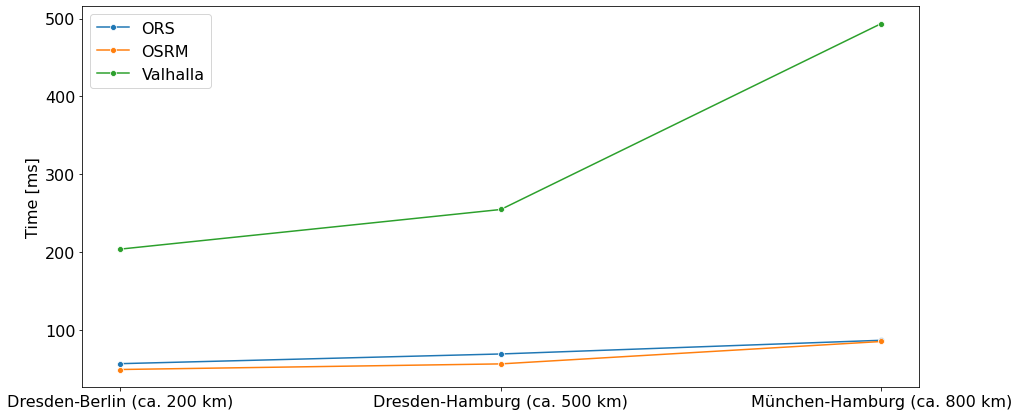

In [182]:
import seaborn as sb
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = '16'

plt.figure(figsize=(15,7))

sb.lineplot(data=_.reset_index(), x="route", y="ORS time [ms]", marker="o", label="ORS")
sb.lineplot(data=_.reset_index(), x="route", y="OSRM time [ms]", marker="o", label="OSRM")
sb.lineplot(data=_.reset_index(), x="route", y="Valhalla time [ms]", marker="o", label="Valhalla")
# plt.xticks(rotation=15)
plt.xlabel("")
plt.ylabel("Time [ms]")
plt.legend();

## Route with Multiple stops

Lets now compara the results of multi stop request in OSRM and Valhalla. Again, for this we will make a request to the eClever route-calculation service collect the resulting stops locations and use them to make the multiple locations request.

In [6]:
import requests
data = {
    "startLocationLng": dresden[0],
    "startLocationLat": dresden[1],
    "destinationLocationLng": hamburg[0],
    "destinationLocationLat": hamburg[1],
    "vehicleVariantId": 432,
}

headers = {"Origin": "dev.eclever.app"}

URL = "https://development.k8s.eclever.net/v1/route-calculation"

response = requests.get(URL, params=data, headers=headers)
link = response.url

route_request = RouteUtil.route_from_link(link)

response = response.json()
solutions = response["routes"]

In [21]:
print("Valhalla Multistop Route")
route_with_stops = get_valhalla_route(route_request, solutions[0]["stops"], "fastest")
plot_route(route_with_stops, solutions[0]["stops"])

print("OSRM Multistop Route")
route_with_stops = get_osrm_route(route_request, solutions[0]["stops"], )
plot_route(route_with_stops, solutions[0]["stops"])

Valhalla Multistop Route
       Distance [km]      Duration [min]    avg Speed [km/h]
____________________________________________________________
               511.7               307.2                99.9



OSRM Multistop Route
       Distance [km]      Duration [min]    avg Speed [km/h]
____________________________________________________________
               510.8               317.5                96.5



The figures above show the result of a calculated route between Dresden and Hamburg together with the charging stops. The route was retrieved using Valhalla (upper map) and OSRM (lower map). As can be seen both routes are the same. Regarding the problem we discussed earlier about the difference of routes between Valhalla and OSRM, the inclusion of additional stops restraints the final route in both APIs. However, the problem will still show up, if the distances between stops is large and there are alternative fast routes in between them.

Another thing that can be observed from the figures an tables above is that, although the route is the same, the estimation of time, distance and average speed is a bit different. For example, Valhalla estimates a route distance of 511.7km whereas OSRM estimates 510.8km. The discrepancy emerges because they use different route graphs. It would be worth trying to have a single source of route graph for both APIs, if that is possible.

### Performance test
Now lets check the performance by measuring the request time similar as before, i.e., getting the mean time from 100 requests:

As observed in the table below, the request time for this particular route with additional stops takes about 3 times longer with Valhalla as compared with ORS. On the other hand, OSRM is again, about 15% faster than ORS.
Comparing Valhalla and OSRM, Valhalla takes almost four times longer than OSRM for multi stop requests.

In [190]:
_=time_route(dresden, hamburg, solutions[0]["stops"])
_["route"] = "Dresden-Hamburg (ca. 500 km)"
_.set_index("route").T

route                  Dresden-Hamburg (ca. 500 km)
ORS time [ms]                                 79.67
Valhalla time [ms]                           261.43
OSRM time [ms]                                70.34
Ratio (Valhalla/ORS)                           3.28
Ratio (OSRM/ORS)                               0.88
Ratio (Valhalla/OSRM)                          3.72

## Time/Distance Matrices

Next step is the evaluation of time/distance matrix request. As a remainder, time/distance matrices are use within the route-calculation service to calculate the energy that an electric vehicle will consume to travel from one location to another. This data is vital for the optimization process that finally decides which charge stations to pick for a given route. 

These matrices typically are considered between the starting route location, the destination location and 100 possible charge stations that are preselected along the route. Hence, one single request calculates the distance and times of about 102x102 = 10404 routes.

Currently, the time/distance matrix request is one of the bottlenecks of our routing algorithm taking, depending on the route, about half of the request time.

### Performance test

In this section we will compare the performance of the matrix API from Valhalla, OSRM and ORS and see if there is an improvement with respect to the currently used ORS API.

To to that we will get some station locations data for a route between Dresden and Hamburg and perform a matrix request using all routing APIs and collect the request runtimes. We will repeat the procedure 20 times and will come with an average request time.

In [7]:
with DatabaseHelper.connect_mongodb() as mongo_connection:
    pg_connection_pool = DatabaseHelper.connect_db_pool()

    try:
        (
            vehicle_type_df,
            plugs_df,
            vehicle_connectors,
            tariffs
        ) = RouteService.collect_auto_user_data(
            route_request, pg_connection_pool, mongo_connection
        )

        route_data = RouteService.calculate_route_data(
        route_request,
        vehicle_type_df,
        plugs_df,
        vehicle_connectors,
        pg_connection_pool=pg_connection_pool,
        mongo_connection=mongo_connection,
        )

    finally:
        mongo_connection.close()
        pg_connection_pool.closeall()

nodes_loc = [route_data["nodes"][node]["location"] for i, node in enumerate(route_data["nodes"])]

In [87]:
from timeit import default_timer as timer

def get_valhalla_time_distance_matrix(nodes_locations, preference):
    """
    Returns the time/distance matrices between the given nodes.

    Parameters:
        ors_client (object) : ORS client
        modes_locations (list) : nodes locations (lat, lon).
    """
    if preference == "fastest":
        route = VALHALLA_CLIENT.matrix(
            locations=nodes_locations,
            preference=preference,
            profile="auto",
        )
    else:
        route = VALHALLA_CLIENT.matrix(
            locations=nodes_locations,
            options={"shortest":True},
            profile="auto",
        )
    
    return route.distances, route.durations


def get_osrm_time_distance_matrix(nodes_locations):
    """
    Returns the time/distance matrices between the given nodes.

    Parameters:
        ors_client (object) : ORS client
        modes_locations (list) : nodes locations (lat, lon).
    """
    route = OSRM_CLIENT.matrix(
        locations=nodes_locations,
        profile="driving",
        annotations=["duration", "distance"],
    )
    
    return route.distances, route.durations

def time_request(locs, number):
    f1_times = []
    f2_times = []
    f3_times = []
    for t in range(number):
        start_time = timer()
        get_valhalla_time_distance_matrix(locs, "fastest")
        f1_times.append((timer() - start_time))

        start_time = timer()
        get_osrm_time_distance_matrix(locs)
        f2_times.append((timer() - start_time))

        start_time = timer()
        RouteService.get_time_distance_matrix(None, locs)
        f3_times.append((timer() - start_time))
    return pd.DataFrame({
        "Valhalla":f1_times,
        "OSRM":f2_times,
        "ORS":f3_times,
    })

In [177]:
test = time_request(nodes_loc, 20)

pd.DataFrame({
    "Valhalla": [f"{test.Valhalla.mean():.2f} \u00B1 {test.Valhalla.std():.2f} s"],
    "OSRM": [f"{test.OSRM.mean():.2f} \u00B1 {test.OSRM.std():.2f} s"],
    "ORS": [f"{test.ORS.mean():.2f} \u00B1 {test.ORS.std():.2f} s"],
    "Ratio (Vallhalla/ORS)": [f"{test.Valhalla.mean()/test.ORS.mean():.2f}"],
    "Ratio (OSRM/ORS)": [f"{test.OSRM.mean()/test.ORS.mean():.2f}"],
    "Ratio (Vallhalla/OSRM)": [f"{test.Valhalla.mean()/test.OSRM.mean():.2f}"],
}, index=["mean matrix runtime (102x102 locations)"]).T

mean matrix runtime (102x102 locations)
Valhalla                                        14.77 ± 0.38 s
OSRM                                             2.61 ± 0.04 s
ORS                                              3.02 ± 0.07 s
Ratio (Vallhalla/ORS)                                     4.89
Ratio (OSRM/ORS)                                          0.86
Ratio (Vallhalla/OSRM)                                    5.67

The table above shows the result of the performance test. Again, the table shows the mean request time or each API, together with their ration. Here we see again that matrix request time is about 14 seconds which is about 5 times slower than ORS and almost 6 times slower than OSRM.

We also see that OSRM is faster than the currently used ORS API, being about 15% faster, which is already a nice improvement.

For visualization, below is a bar plot of the mean request times for all APIs, showing the large request time from Valhalla in comparison with the other two APIs. 

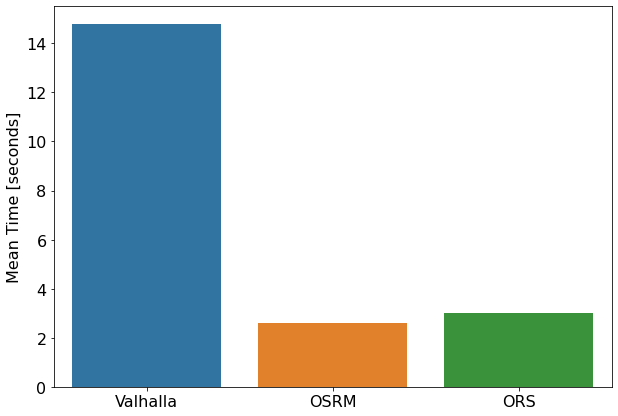

In [199]:
cols = ["Valhalla", "OSRM", "ORS"]
plt.rcParams['font.size'] = '16'

plt.figure(figsize=(10,7))
sb.barplot(x=cols, y=[test[col].mean() for col in cols])
plt.ylabel("Mean Time [seconds]");

### Route preference (Fastest/Shortest)

As reported in our [previous report](https://eclever.atlassian.net/wiki/spaces/DEV/pages/3119513605/Routing+API+comparison+Valhalla+vs.+OpenRouteService), the Valhalla API was capable to yield time/distance matrices for the case when the route preference was fastest or shortest. Unfortunately, OSRM API does not have this option, moreover, it does not have the option of selecting the shortest route for a simple A to B route request.

However, OSRM has the option to request alternative routes from a simple A to B route. Although, the return of alternative routes is not warranted. Anyhow, this feature can be used to yield alternative routes in the route calculation service.

The maps below shows a request to the OSRM API, where we have requested a route from München to Hamburg with three alternatives. 

In [269]:
def plot_route_multi(start, end):

    route = OSRM_CLIENT.directions(
        locations=[start, end],
        profile="driving",
        geometries="geojson",
        overview="full",
        alternatives=2
        )
    routes = [route for route in route]
    
    bounding_array = np.array(routes[0].geometry)[:,[1,0]]

    m = folium.Map()
    m.fit_bounds(
        [
            (bounding_array[:, 0].min(), bounding_array[:, 1].min()),
            (bounding_array[:, 0].max(), bounding_array[:, 1].max()),
        ]
    )
    
    colors = {0:"blue", 1:"green", 2:"red"}

    for i, r in enumerate(routes):
        line = np.array(r.geometry)[:,[1,0]]
        folium.vector_layers.PolyLine(locations=line, color=colors[i]).add_to(m)

        start = line[0] 
        end = line[-1] 
        
        distance = r.distance/1000
        time = r.duration/3600
        
        print(f"route {i+1} ({colors[i]}): Distance: {distance:.0f} km, Duration: {time:.1f} h, av. Speed: {distance/time:.0f} km/h")

        folium.Marker(start,tooltip="Start", icon = folium.Icon(icon="glyphicon-map-marker",color='red')).add_to(m)
        folium.Marker(end,tooltip="End", icon = folium.Icon(icon="glyphicon-flag",color='green')).add_to(m)

    display(m) 

plot_route_multi(hamburg, muenchen)

route 1 (blue): Distance: 793 km, Duration: 7.7 h, av. Speed: 103 km/h
route 2 (green): Distance: 780 km, Duration: 8.0 h, av. Speed: 97 km/h
route 3 (red): Distance: 834 km, Duration: 8.1 h, av. Speed: 103 km/h


## Elevation

Regarding elevation, the OSRM API has no elevation request option, this again, is only possible with ORS and Valhalla. Remember also, that in order to add elevation information to the locations that we need, a second request will be required. This is in contrast to ORS where the requested routes are returned with elevation information.

### Performance test

The performance test is done similar to the ones we have done so far, we will perform an elevation request to the APIs and collect the average of 100 requests. We will do this for different number of locations.

In [291]:
def get_valhalla_altitude(line):
    """
    Returns the polyline of the final route with charge stops.

    Parameters:
        route_request (object) : route request object
        stops (dict) : dictionary with route stops.
    """
    
    URL = base_url + "/height"
    data = {
        "shape": [{"lat": lat, "lon": lon} for (lon, lat) in line],
            }        
    
    response = requests.get(URL, json=data)
    return response.json()["height"]

def time_elevation(line):
    setup = [
     "from __main__ import get_valhalla_altitude; ", 
     "from services import RouteService; ", 
    ]
    setup = "".join(setup)
    stmt_ors = f"RouteService.get_elevations(None, {line})"
    stmt_valhalla = f"get_valhalla_altitude({line})"
    number = 100

    time_ors = timeit.timeit(stmt=stmt_ors, setup=setup, number=number)/number
    time_valhalla = timeit.timeit(stmt=stmt_valhalla, setup=setup, number=number)/number
    
    _ = pd.DataFrame({
        "ORS time [ms]": [1000*time_ors],
        "Valhalla time [ms]": [1000*time_valhalla],
    })
    _["Ratio (Valhalla/ORS)"] = _["Valhalla time [ms]"]/_["ORS time [ms]"]
    return _.round(2)

In [290]:
t = pd.DataFrame()
for l in [100,500,1000,2000]:
    _ = time_elevation(solutions[0]["polyline"][:l])
    _["locations"] = l
    t = pd.concat([t, _])
    
t.set_index("locations").T

locations              100     500     1000    2000
ORS time [ms]         54.71  204.82  372.72  661.77
Valhalla time [ms]    90.18  136.53  149.71  200.12
Ratio (Valhalla/ORS)   1.65    0.67    0.40    0.30

The table above shows the results of the test. As can be seen for both APIs the mean request time increases with the number of locations. However, for the ORS API this increase is much more pronounced as for Valhalla. This can be better seen in the figure below. Here we can see that for ORS the request time is increased by a factor of two when the amount of locations is doubled. In contrast, Valhalla shows a much lower time increment upon increasing the number of locations, in fact for a large number of locations Valhalla is about 70% faster than ORS. Interestingly, For small number of locations, i.e., 100, ORS is about 65% faster than Valhalla. 

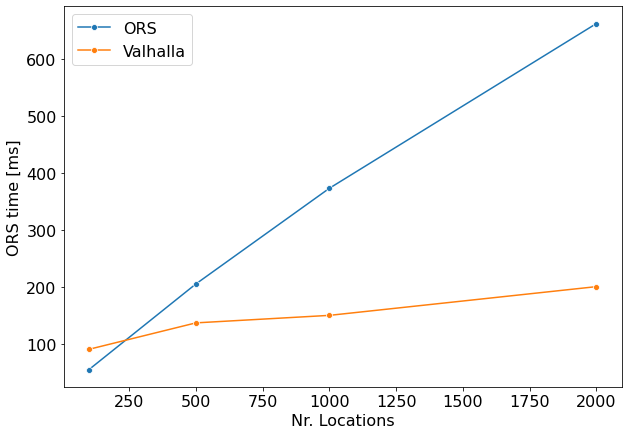

In [304]:
plt.figure(figsize=(10,7))
sb.lineplot(data=t.reset_index(), x="locations", y="ORS time [ms]", marker="o", label="ORS")
sb.lineplot(data=t.reset_index(), x="locations", y="Valhalla time [ms]", marker="o", label="Valhalla")
plt.xlabel("Nr. Locations")
plt.legend();

## Summary and conclusion

To summarize, we have performed a requirements and performance check for the Valhalla and OSRM routing APIs and have compared their results with that of the currently use ORS API, which was used as a benchmark.

Regarding Valhalla, the results are in agreement with our previous study, this is, it fulfills all our requirements such as returning of simple and multi-stop routes, time/distance matrices and elevation. However, the request times take rather long, about 5 times longer that ORS.

OSRM on the other hand, performs much better than ORS in most cases, being about 15% faster. However, there are some features that are not available such as the elevation and route preference (i.e., fastest, shortest). It has though, the option to return alternative routes. This feature can be used in our route-calculation service to return alternative routes, instead to the fastest/shortest option used so far.

Another disadvantage is that both Valhalla and OSRM does not have the option to deliver a route geometry together with the elevation information. To enrich the geometry with elevation a second API call is required.